In [14]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [15]:
import pandas as pd

df = pd.read_csv("Heart Disease Cleveland.csv")
X = df.drop(['target'] ,axis="columns")
y = df['target']

# Feature selection using filter method

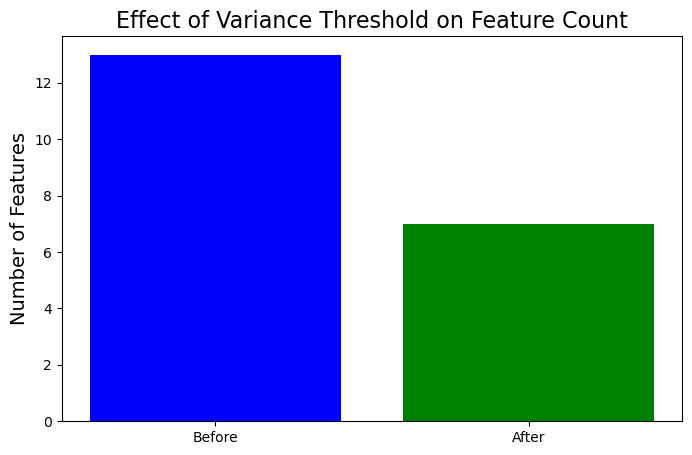

In [17]:
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

variance_threshold = VarianceThreshold(threshold=0.5)  # You can adjust the threshold
X_reduced = variance_threshold.fit_transform(X)

n_features_before = X.shape[1]
n_features_after = X_reduced.shape[1]

plt.figure(figsize=(8, 5))
plt.bar(['Before', 'After'], [n_features_before, n_features_after], color=['blue', 'green'])
plt.title("Effect of Variance Threshold on Feature Count", fontsize=16)
plt.ylabel("Number of Features", fontsize=14)
plt.show()

In [18]:
import numpy as np

features_removed = np.array(X.columns)[variance_threshold.get_support() == False]
print(f"Features removed (low variance): {features_removed}")

Features removed (low variance): ['sex' 'fbs' 'restecg' 'exang' 'slope' 'thal']


In [19]:
X = X.drop(columns = features_removed)
X.head()

,age,cp,trestbps,chol,thalach,oldpeak,ca
0,63,3,145,233,150,2.3,0
1,37,2,130,250,187,3.5,0
2,41,1,130,204,172,1.4,0
3,56,1,120,236,178,0.8,0
4,57,0,120,354,163,0.6,0


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    stratify = y,
                                                    random_state = 42)

In [31]:
import mlflow
import mlflow.sklearn

# Intialize MLflow
mlflow.set_experiment("Heart-Disease-Prediction")
mlflow.set_tracking_uri("http://localhost:5000")

# Train & Evaluate Classical Classifiers

In [21]:
from sklearn.svm import SVC

In [29]:
models = [
    (
        "SVM-linear",
        SVC(kernel = 'linear'),
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "SVM-rbf",
        SVC(kernel = 'rbf'),
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "SVM-sigmoid",
        SVC(kernel = 'sigmoid'),
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "SVM-poly",
        SVC(kernel = 'poly'),
        (X_train, y_train),
        (X_test, y_test)
    )
]

In [30]:
from sklearn.metrics import classification_report

reports = []

for model_name, model, train_set, test_set in models:
    print(f"Training model: {model_name}")

    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.fit(X_train, y_train)
    print(f"Training: {model_name} done")

    y_pred = model.predict(X_test)
    print(f"Evaluating model: {model_name}")
    report = classification_report(y_test, y_pred, output_dict = True)
    reports.append(report)
    
    print(f"Completed {model_name} training.")


Training model: SVM-linear
Training: SVM-linear done
Evaluating model: SVM-linear
Completed SVM-linear training.
Training model: SVM-rbf
Training: SVM-rbf done
Evaluating model: SVM-rbf
Completed SVM-rbf training.
Training model: SVM-sigmoid
Training: SVM-sigmoid done
Evaluating model: SVM-sigmoid
Completed SVM-sigmoid training.
Training model: SVM-poly
Training: SVM-poly done
Evaluating model: SVM-poly
Completed SVM-poly training.


In [31]:
for i, element in enumerate(models):
    model_name = element[0]
    model = element[1]
    report = reports[i]

    with mlflow.start_run(run_name = model_name):
        mlflow.log_param("model", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('recall_class_1', report['1']['recall'])
        mlflow.log_metric('recall_class_0', report['0']['recall'])
        mlflow.log_metric('f1_class_1', report['1']['f1-score'])
        mlflow.log_metric('f1_class_0', report['0']['f1-score'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])        

        mlflow.sklearn.log_model(model, "model")

2025/01/05 13:32:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/05 13:32:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM-linear at: http://localhost:5000/#/experiments/828182524060726479/runs/33c5969c69494ffe99b61c6a2663aef6.
2025/01/05 13:32:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/828182524060726479.
2025/01/05 13:32:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/05 13:32:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM-rbf at: http://localhost:5000/#/experiments/828182524060726479/runs/6bbb5a0b878b46a3a2df261f15c15515.
2025/01/05 13:32:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: htt

# Train & Evaluate Quantum Classifiers

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    stratify = y,
                                                    random_state = 42)

In [22]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile

In [24]:
# Function to create a quantum kernel
def create_kernel(num_features, num_reps, entanglement_type):
    # Initialize feature map
    feature_map = ZZFeatureMap(feature_dimension=num_features,
                               reps=num_reps,
                               entanglement=entanglement_type)
    
    # Define the sampler
    sampler = Sampler()

    # Compute fidelities
    fidelity = ComputeUncompute(sampler=sampler)

    # Create a quantum kernel
    kernel = FidelityQuantumKernel(fidelity=fidelity,
                                   feature_map=feature_map)

    return kernel

In [25]:
num_features = X_train.shape[1]

In [26]:
# Define models with quantum kernels
models = [
    (
        "QSVM-linear",
        QSVC(quantum_kernel=create_kernel(num_features, num_reps=1, entanglement_type="linear")),
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "QSVM-circular",
        QSVC(quantum_kernel=create_kernel(num_features, num_reps=1, entanglement_type="circular")),
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "QSVM-full",
        QSVC(quantum_kernel=create_kernel(num_features, num_reps=1, entanglement_type="full")),
        (X_train, y_train),
        (X_test, y_test)
    )
]

In [27]:
from sklearn.metrics import classification_report

reports = []

for model_name, model, train_set, test_set in models:
    print(f"Training model: {model_name}")

    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.fit(X_train, y_train)
    print(f"Training: {model_name} done")

    y_pred = model.predict(X_test)
    print(f"Evaluating model: {model_name}")
    report = classification_report(y_test, y_pred, output_dict = True)
    reports.append(report)
    
    print(f"Completed {model_name} training.")


Training model: QSVM-linear
Training: QSVM-linear done
Evaluating model: QSVM-linear
Completed QSVM-linear training.
Training model: QSVM-circular
Training: QSVM-circular done
Evaluating model: QSVM-circular
Completed QSVM-circular training.
Training model: QSVM-full
Training: QSVM-full done
Evaluating model: QSVM-full
Completed QSVM-full training.


In [33]:
import mlflow
from mlflow.models import Model
import cloudpickle
import os

class QuantumModelWrapper:
    """Wrapper class to make quantum models MLflow-compatible"""
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        return self.model.predict(X)
    
def log_quantum_model(model, artifact_path):
    """
    Log a quantum model to MLflow.
    
    Parameters:
    -----------
    model : QSVC
        The quantum model to log
    artifact_path : str
        Directory in the MLflow run to store the model
    """
    # Save the model using cloudpickle
    os.makedirs(artifact_path, exist_ok=True)
    model_path = os.path.join(artifact_path, "model.pkl")
    
    # Wrap the quantum model
    wrapped_model = QuantumModelWrapper(model)
    
    with open(model_path, "wb") as f:
        cloudpickle.dump(wrapped_model, f)
    
    # Create MLflow Model
    mlflow_model = Model()
    
    # Add the python_function flavor
    mlflow_model.add_flavor("python_function", 
                           loader_module="mlflow.pyfunc.model",
                           data=model_path)
    
    # Save the MLflow Model
    mlflow_model.save(os.path.join(artifact_path, "MLmodel"))
    
    return mlflow_model

In [32]:
for i, element in enumerate(models):
    model_name = element[0]
    model = element[1]
    report = reports[i]

    with mlflow.start_run(run_name = model_name):
        mlflow.log_param("model", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('recall_class_1', report['1']['recall'])
        mlflow.log_metric('recall_class_0', report['0']['recall'])
        mlflow.log_metric('f1_class_1', report['1']['f1-score'])
        mlflow.log_metric('f1_class_0', report['0']['f1-score'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])        

        log_quantum_model(model, "model")

2025/01/05 16:13:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run QSVM-linear at: http://localhost:5000/#/experiments/828182524060726479/runs/52962d1c57cb4b47a311db4eac69490a.
2025/01/05 16:13:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/828182524060726479.
2025/01/05 16:13:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run QSVM-circular at: http://localhost:5000/#/experiments/828182524060726479/runs/d5370675c60a414fb9c9fa1dfa9849d4.
2025/01/05 16:13:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/828182524060726479.
2025/01/05 16:13:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run QSVM-full at: http://localhost:5000/#/experiments/828182524060726479/runs/5341bfca60de4b608708cd60a074aaf4.
2025/01/05 16:13:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/828182524060726479.


# Bagging QSVC

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier


In [36]:
qsvc = QSVC(quantum_kernel=create_kernel(num_features, 
                                         num_reps=1, 
                                         entanglement_type="linear"))

In [39]:
pipeline = make_pipeline(qsvc)
pipeline

Pipeline(steps=[('qsvc',
                 QSVC(C=1.0, break_ties=False, cache_size=200,
                      class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=3, gamma='scale',
                      max_iter=-1, probability=False,
                      quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x0000022B9C6EAF70>,
                      random_state=None, shrinking=True, tol=0.001,
                      verbose=False))])

In [44]:
import numpy as np
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from typing import Optional
import time
from tqdm import tqdm

class QuantumClassifierWrapper(BaseEstimator, ClassifierMixin):
    """Wrapper for quantum classifiers to make them work with sklearn's BaggingClassifier"""
    def __init__(self, quantum_kernel, num_features, num_reps=1, entanglement_type="linear", verbose=True):
        self.quantum_kernel = quantum_kernel
        self.num_features = num_features
        self.num_reps = num_reps
        self.entanglement_type = entanglement_type
        self.qsvc = None
        self.verbose = verbose
        
    def fit(self, X, y):
        if self.verbose:
            print(f"\nInitializing quantum kernel with {self.num_features} features...")
            start_time = time.time()
            
        kernel = create_kernel(self.num_features, 
                             self.num_reps, 
                             self.entanglement_type)
        
        if self.verbose:
            print(f"Kernel creation took {time.time() - start_time:.2f} seconds")
            print("Creating QSVC instance...")
            
        self.qsvc = QSVC(quantum_kernel=kernel)
        
        if self.verbose:
            print(f"Starting QSVC fit on {len(X)} samples...")
            start_time = time.time()
            
        self.qsvc.fit(X, y)
        
        if self.verbose:
            print(f"QSVC fitting completed in {time.time() - start_time:.2f} seconds")
            
        return self
        
    def predict(self, X):
        if self.qsvc is None:
            raise ValueError("Classifier not fitted yet.")
            
        if self.verbose:
            print(f"\nStarting prediction on {len(X)} samples...")
            start_time = time.time()
            
        predictions = self.qsvc.predict(X)
        
        if self.verbose:
            print(f"Prediction completed in {time.time() - start_time:.2f} seconds")
            
        return predictions

def create_quantum_bagging_classifier(X_train, n_estimators=3, random_state=1, verbose=True):
    """
    Create a bagging classifier with quantum base estimators
    """
    if verbose:
        print("\n=== Initializing Quantum Bagging Classifier ===")
        print(f"Number of estimators: {n_estimators}")
        print(f"Input features: {X_train.shape[1]}")
        
    num_features = X_train.shape[1]
    
    base_classifier = QuantumClassifierWrapper(
        quantum_kernel=create_kernel,
        num_features=num_features,
        num_reps=1,
        entanglement_type="linear",
        verbose=verbose
    )
    
    if verbose:
        print("\nCreating bagging ensemble...")
        
    bgqclassifier = BaggingClassifier(
        estimator=base_classifier,
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=1,
        verbose=3  # Enable sklearn's built-in verbosity
    )
    
    return bgqclassifier

# Training with progress bar
print("\n=== Starting Quantum Ensemble Training ===")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

start_time = time.time()
bgqclassifier = create_quantum_bagging_classifier(X_train, verbose=True)

print("\nFitting ensemble...")
with tqdm(total=bgqclassifier.n_estimators, desc="Training estimators") as pbar:
    # Store the original fit method
    original_fit = bgqclassifier.fit
    
    # Create a wrapper that updates the progress bar
    def fit_with_progress(X, y):
        result = original_fit(X, y)
        pbar.update(bgqclassifier.n_estimators)
        return result
    
    # Replace the fit method
    bgqclassifier.fit = fit_with_progress
    
    # Fit the model
    bgqclassifier.fit(X_train, y_train)

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")


=== Starting Quantum Ensemble Training ===
Training data shape: (242, 7)
Test data shape: (61, 7)

=== Initializing Quantum Bagging Classifier ===
Number of estimators: 3
Input features: 7

Creating bagging ensemble...

Fitting ensemble...


Training estimators:   0%|                                                                       | 0/3 [00:00<?, ?it/s]

Building estimator 1 of 3 for this parallel run (total 3)...

Initializing quantum kernel with 7 features...
Kernel creation took 0.01 seconds
Creating QSVC instance...
Starting QSVC fit on 242 samples...
QSVC fitting completed in 196.97 seconds
Building estimator 2 of 3 for this parallel run (total 3)...

Initializing quantum kernel with 7 features...
Kernel creation took 0.00 seconds
Creating QSVC instance...
Starting QSVC fit on 242 samples...
QSVC fitting completed in 211.28 seconds
Building estimator 3 of 3 for this parallel run (total 3)...

Initializing quantum kernel with 7 features...
Kernel creation took 0.00 seconds
Creating QSVC instance...
Starting QSVC fit on 242 samples...


Training estimators: 100%|██████████████████████████████████████████████████████████████| 3/3 [10:27<00:00, 209.27s/it]

QSVC fitting completed in 217.90 seconds

Total training time: 629.42 seconds



Starting prediction on 61 samples...
Prediction completed in 105.80 seconds

Starting prediction on 61 samples...
Prediction completed in 110.22 seconds

Starting prediction on 61 samples...
Prediction completed in 107.27 seconds


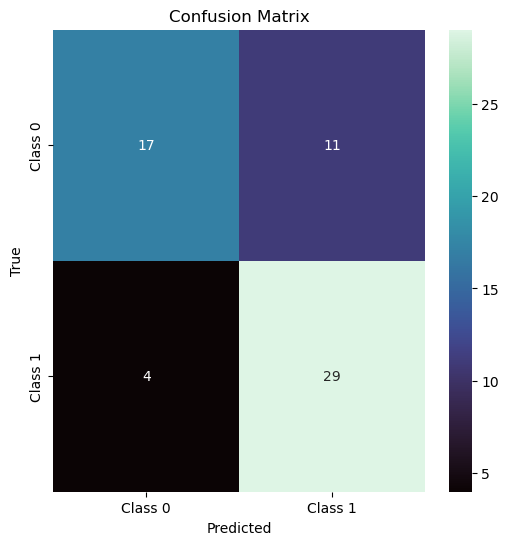

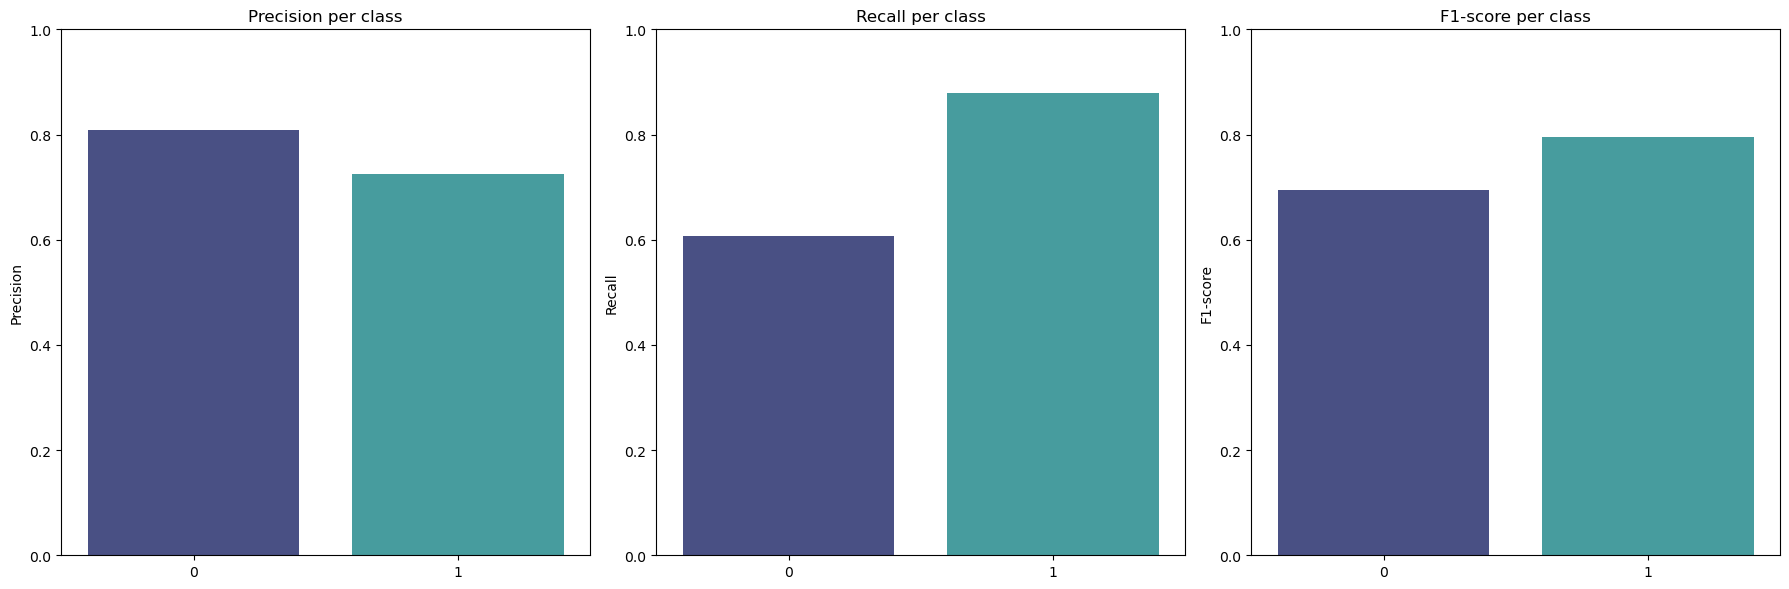

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = bgqclassifier.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="mako", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2. Precision, Recall, and F1-Score for each class
metrics = ['precision', 'recall', 'f1-score']
labels = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', and 'weighted avg'

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    values = [report[class_label][metric] for class_label in labels]
    sns.barplot(x=labels, y=values, palette="mako", ax=axes[i])
    axes[i].set_title(f"{metric.capitalize()} per class")
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [46]:
# Log the metrics and plots in MLflow
with mlflow.start_run(run_name = "Bagging-3xQSVC-linear"):
    mlflow.log_metric("accuracy", report["accuracy"])
    mlflow.log_metric("f1_score_macro", report["macro avg"]["f1-score"])
    mlflow.log_metric("recall_class_1", report['1']['recall'])
    mlflow.log_metric("f1_class_1", report['1']['f1-score'])
    mlflow.log_metric("f1_class_0", report['0']['f1-score'])

2025/01/05 16:41:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Bagging-3xQSVC-linear at: http://localhost:5000/#/experiments/828182524060726479/runs/a154b6906d5740bf841b4e721d691c6e.
2025/01/05 16:41:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/828182524060726479.


* The QSVC with linear entanglement give us the highest F1-macro

# Save the models

In [54]:
models[0][1]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x0000022BFB11F220>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [56]:
models[0][1].save('model/qsvc_linear.model')

In [57]:
bgqclassifier

BaggingClassifier(estimator=QuantumClassifierWrapper(num_features=7,
                                                     quantum_kernel=<function create_kernel at 0x0000022BF827B790>),
                  n_estimators=3, n_jobs=1, random_state=1, verbose=3)

In [58]:
from joblib import dump, load

dump(bgqclassifier, 'model/bgqclassifier_model.joblib')

['model/bgqclassifier_model.joblib']